In [1]:
# ============================================================================
# MOD002691 - FINAL PROJECT: MODEL COMPARISON ANALYSIS
# ============================================================================
#
# Author:       Oriol Morros Vilaseca (SID: 2270056)
# Supervisor:   Mr Vitaliy Milke
# Institution:  Anglia Ruskin University, Cambridge
# Module:       MOD002691 - Final Project (BSc Software Engineering)
# Date:         January 2026
#
# ============================================================================
# PURPOSE
# ============================================================================
#
# Comprehensive comparison of three trained models for food classification:
#   1. Custom CNN (baseline, trained from scratch)
#   2. EfficientNetB0 (transfer learning)
#   3. ResNet-50 (transfer learning)
#
# This notebook loads pre-computed results from individual training runs
# and generates comparative visualisations and statistical analysis.
#
# ============================================================================

In [2]:
# ============================================================================
# CELL 2: ENVIRONMENT SETUP
# ============================================================================

import sys
import platform
from datetime import datetime

print("=" * 70)
print("MODEL COMPARISON ANALYSIS")
print("=" * 70)
print(f"Execution:  {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python:     {sys.version.split()[0]}")
print(f"Platform:   {platform.platform()}")
print("=" * 70)

MODEL COMPARISON ANALYSIS
Execution:  2026-01-26 17:29:10
Python:     3.12.12
Platform:   Linux-6.6.105+-x86_64-with-glibc2.35


In [3]:
# ============================================================================
# CELL 3: IMPORTS
# ============================================================================

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from google.colab import drive
drive.mount('/content/drive')

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

COLORS = {'Custom CNN': '#2ecc71', 'EfficientNetB0': '#3498db', 'ResNet-50': '#e74c3c'}

print("Imports complete.")

Mounted at /content/drive
Imports complete.


In [ ]:
# ============================================================================
# CELL 4: LOAD TRAINING RESULTS
# ============================================================================
# Load pre-computed results JSON files from individual training notebooks.
# ============================================================================

print("=" * 70)
print("LOADING RESULTS")
print("=" * 70)

RESULTS_DIR = "/content/drive/MyDrive/snapshelf_models_v2"

# Load each model's results
with open(f"{RESULTS_DIR}/custom_cnn_results.json", 'r') as f:
    custom_cnn = json.load(f)
    print("Loaded: Custom CNN results")

with open(f"{RESULTS_DIR}/efficientnet_results.json", 'r') as f:
    efficientnet = json.load(f)
    print("Loaded: EfficientNetB0 results")

with open(f"{RESULTS_DIR}/resnet50_results.json", 'r') as f:
    resnet50 = json.load(f)
    print("Loaded: ResNet-50 results")

results = {
    'Custom CNN': custom_cnn,
    'EfficientNetB0': efficientnet,
    'ResNet-50': resnet50
}

# ============================================================================
# TRAINING TIME CORRECTION: Custom CNN
# ============================================================================
# The Custom CNN training was interrupted by a Colab runtime disconnection
# at epoch 66. Training resumed from the epoch 65 checkpoint (saved every
# 5 epochs). The runtime timer only captured the resumed session (epochs
# 65-81 = 16 epochs in 17,391s) because the crash prevented the first
# session's wall-clock time from being recorded.
#
# Correction method:
#   per_epoch = 17,391s / 16 epochs = 1,086.9s/epoch
#   estimated_total = 1,086.9 * 81 epochs = 89,129s (24.76h)
#
# This per-epoch extrapolation is valid because per-epoch training time
# is approximately constant for a fixed architecture, dataset, and GPU.
# ============================================================================

RECORDED_SESSION_SECONDS = 17391
RECORDED_SESSION_EPOCHS = 16   # epochs 65-81 (resumed from checkpoint)
TOTAL_EPOCHS = 81

per_epoch_seconds = RECORDED_SESSION_SECONDS / RECORDED_SESSION_EPOCHS
corrected_total_seconds = per_epoch_seconds * TOTAL_EPOCHS

print(f"\n[Training Time Correction: Custom CNN]")
print(f"  Recorded (incomplete):   {RECORDED_SESSION_SECONDS:,.0f}s ({RECORDED_SESSION_SECONDS/3600:.2f}h)")
print(f"  Per-epoch rate:          {per_epoch_seconds:,.1f}s ({per_epoch_seconds/60:.1f} min)")
print(f"  Corrected total:         {corrected_total_seconds:,.0f}s ({corrected_total_seconds/3600:.2f}h)")

results['Custom CNN']['training']['training_time_seconds'] = corrected_total_seconds

print(f"\nAll results loaded from: {RESULTS_DIR}")

In [5]:
# ============================================================================
# CELL 5: PERFORMANCE SUMMARY TABLE
# ============================================================================
# Consolidated view of key metrics across all models.
# ============================================================================

print("=" * 70)
print("PERFORMANCE SUMMARY")
print("=" * 70)

summary_data = []
for name, r in results.items():
    hours = r['training']['training_time_seconds'] / 3600
    summary_data.append({
        'Model': name,
        'Test Accuracy (%)': round(r['performance']['test_accuracy'] * 100, 2),
        'Test Loss': round(r['performance']['test_loss'], 4),
        'Parameters (M)': round(r['efficiency']['total_parameters'] / 1e6, 2),
        'Model Size (MB)': r['efficiency']['model_size_mb'],
        'Training Time (h)': round(hours, 2),
        'Inference (ms)': r['efficiency']['inference_time_single_ms'],
        'Pretrained': 'No' if name == 'Custom CNN' else 'Yes'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Highlight best values
print("\n" + "-" * 70)
print("[Best Performance]")
best_acc_idx = summary_df['Test Accuracy (%)'].idxmax()
best_size_idx = summary_df['Model Size (MB)'].idxmin()
best_time_idx = summary_df['Training Time (h)'].idxmin()
print(f"  Highest Accuracy:  {summary_df.loc[best_acc_idx, 'Model']} ({summary_df.loc[best_acc_idx, 'Test Accuracy (%)']}%)")
print(f"  Smallest Model:    {summary_df.loc[best_size_idx, 'Model']} ({summary_df.loc[best_size_idx, 'Model Size (MB)']} MB)")
print(f"  Fastest Training:  {summary_df.loc[best_time_idx, 'Model']} ({summary_df.loc[best_time_idx, 'Training Time (h)']} hours)")

PERFORMANCE SUMMARY
         Model  Test Accuracy (%)  Test Loss  Parameters (M)  Model Size (MB)  Training Time (h)  Inference (ms) Pretrained
    Custom CNN              97.97     0.0588            4.96            56.92              14.78           64.12         No
EfficientNetB0              99.75     0.0144            4.07            40.03               6.67           66.95        Yes
     ResNet-50              99.76     0.0153           24.13           211.03              10.34           69.18        Yes

----------------------------------------------------------------------
[Best Performance]
  Highest Accuracy:  ResNet-50 (99.76%)
  Smallest Model:    EfficientNetB0 (40.03 MB)
  Fastest Training:  EfficientNetB0 (6.67 hours)


ACCURACY COMPARISON


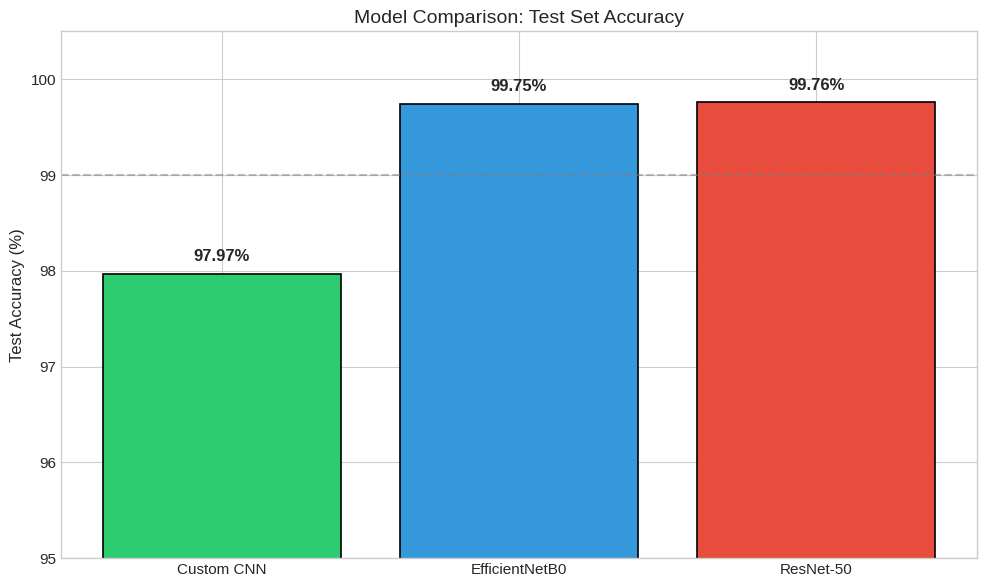


Plot saved: comparison_accuracy.png


In [6]:
# ============================================================================
# CELL 6: ACCURACY COMPARISON
# ============================================================================

print("=" * 70)
print("ACCURACY COMPARISON")
print("=" * 70)

fig, ax = plt.subplots(figsize=(10, 6))

models = list(results.keys())
accuracies = [r['performance']['test_accuracy'] * 100 for r in results.values()]
colors = [COLORS[m] for m in models]

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Model Comparison: Test Set Accuracy')
ax.set_ylim(95, 100.5)
ax.axhline(y=99, color='gray', linestyle='--', alpha=0.5, label='99% threshold')

plt.tight_layout()
plt.savefig('/content/comparison_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_accuracy.png")

EFFICIENCY COMPARISON


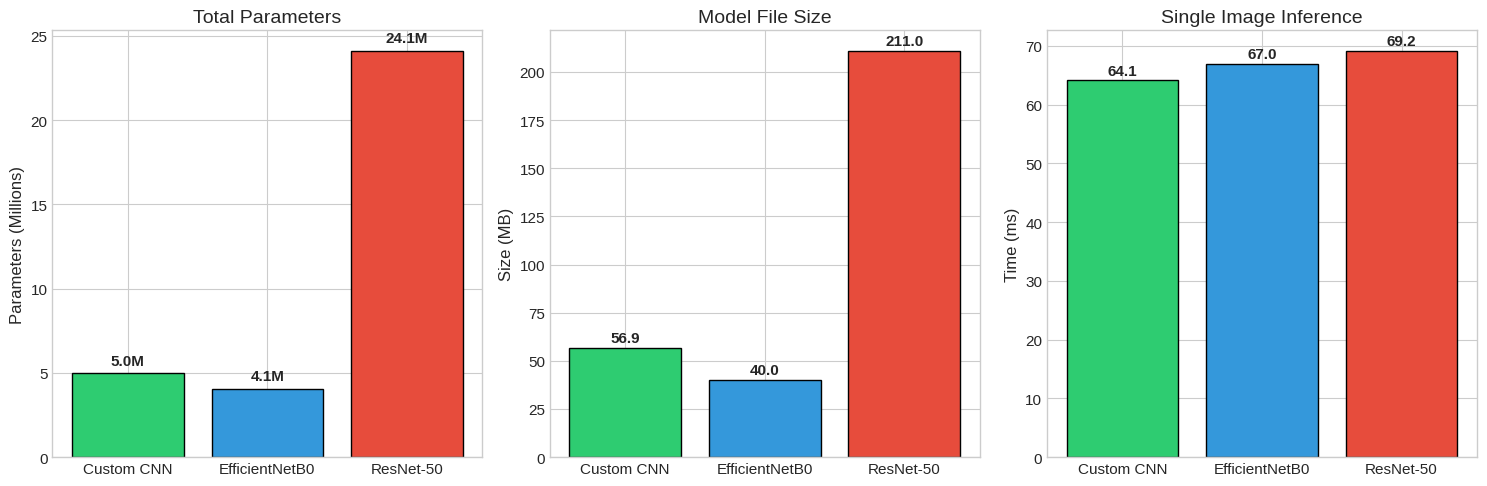


Plot saved: comparison_efficiency.png


In [7]:
# ============================================================================
# CELL 7: EFFICIENCY COMPARISON
# ============================================================================
# Compare model size, parameters, and inference time.
# ============================================================================

print("=" * 70)
print("EFFICIENCY COMPARISON")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = list(results.keys())
colors = [COLORS[m] for m in models]

# Parameters
params = [r['efficiency']['total_parameters'] / 1e6 for r in results.values()]
axes[0].bar(models, params, color=colors, edgecolor='black')
axes[0].set_ylabel('Parameters (Millions)')
axes[0].set_title('Total Parameters')
for i, (m, p) in enumerate(zip(models, params)):
    axes[0].text(i, p + 0.5, f'{p:.1f}M', ha='center', fontweight='bold')

# Model Size
sizes = [r['efficiency']['model_size_mb'] for r in results.values()]
axes[1].bar(models, sizes, color=colors, edgecolor='black')
axes[1].set_ylabel('Size (MB)')
axes[1].set_title('Model File Size')
for i, (m, s) in enumerate(zip(models, sizes)):
    axes[1].text(i, s + 3, f'{s:.1f}', ha='center', fontweight='bold')

# Inference Time
inf_times = [r['efficiency']['inference_time_single_ms'] for r in results.values()]
axes[2].bar(models, inf_times, color=colors, edgecolor='black')
axes[2].set_ylabel('Time (ms)')
axes[2].set_title('Single Image Inference')
for i, (m, t) in enumerate(zip(models, inf_times)):
    axes[2].text(i, t + 1, f'{t:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/comparison_efficiency.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_efficiency.png")

PER-CLASS F1 SCORE COMPARISON


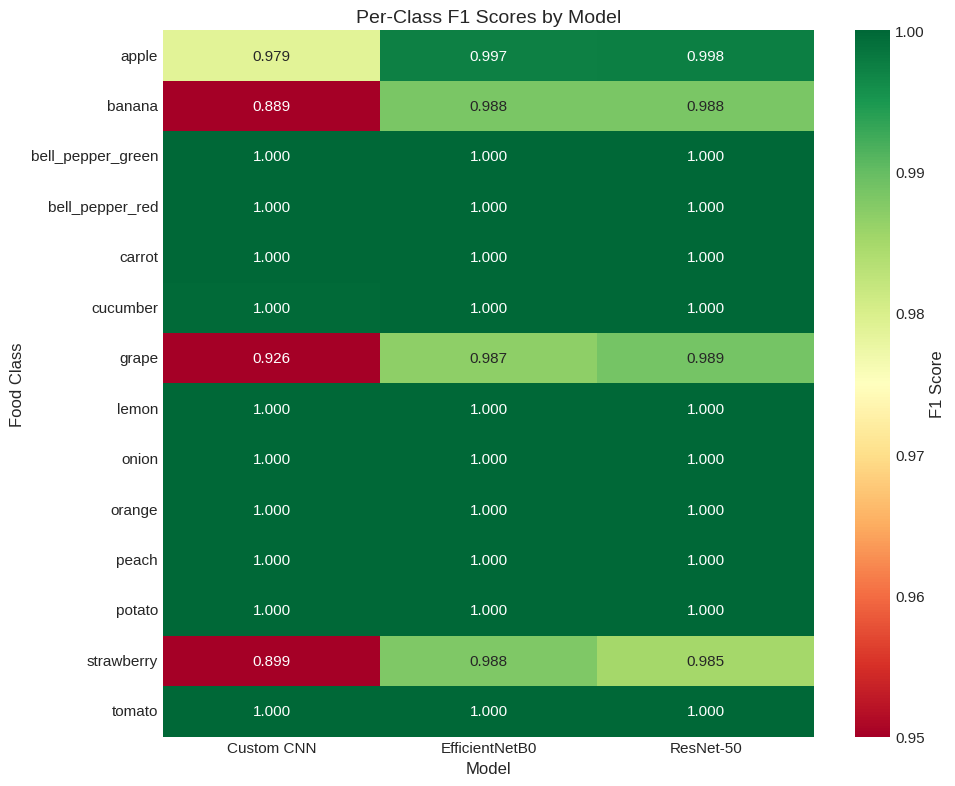


[Custom CNN Weakest Classes]
  banana: 0.8890
  strawberry: 0.8993
  grape: 0.9262

Plot saved: comparison_f1_heatmap.png


In [8]:
# ============================================================================
# CELL 8: PER-CLASS F1 SCORE COMPARISON
# ============================================================================
# Heatmap showing F1 scores across all classes for each model.
# ============================================================================

print("=" * 70)
print("PER-CLASS F1 SCORE COMPARISON")
print("=" * 70)

# Extract class names from first model
class_names = list(results['Custom CNN']['per_class_metrics'].keys())

# Build F1 matrix
f1_data = {}
for model_name, r in results.items():
    f1_data[model_name] = [r['per_class_metrics'][c]['f1_score'] for c in class_names]

f1_df = pd.DataFrame(f1_data, index=class_names)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(f1_df, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0.95, vmax=1.0, ax=ax, cbar_kws={'label': 'F1 Score'})
ax.set_title('Per-Class F1 Scores by Model')
ax.set_xlabel('Model')
ax.set_ylabel('Food Class')

plt.tight_layout()
plt.savefig('/content/comparison_f1_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Print classes where Custom CNN struggles
print("\n[Custom CNN Weakest Classes]")
cnn_f1 = pd.Series(f1_data['Custom CNN'], index=class_names).sort_values()
for cls, score in cnn_f1.head(3).items():
    print(f"  {cls}: {score:.4f}")

print("\nPlot saved: comparison_f1_heatmap.png")

TRAINING TIME VS ACCURACY


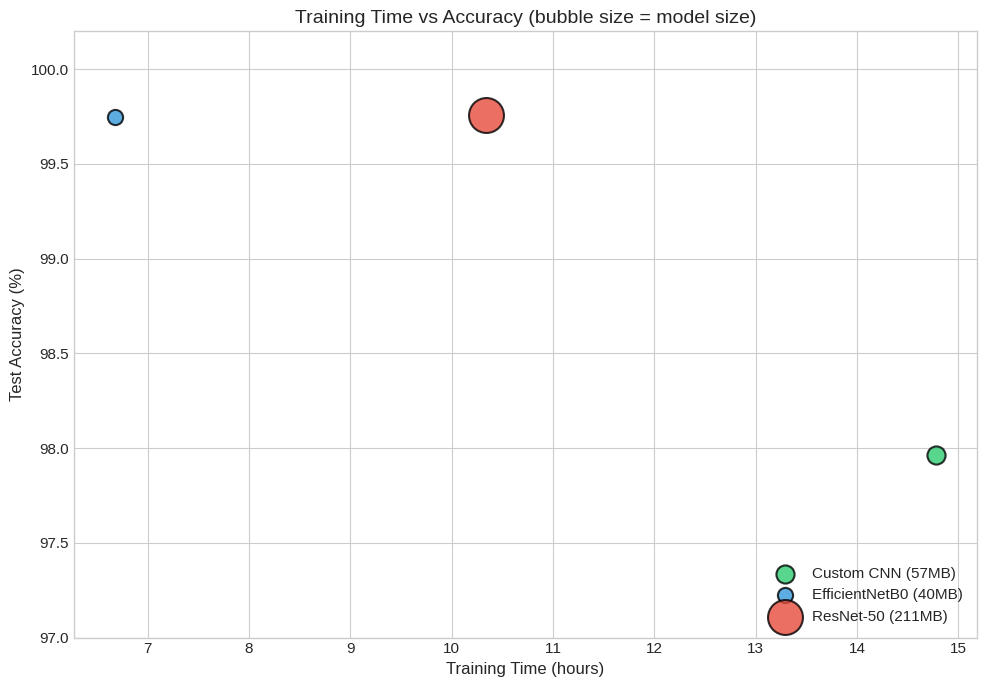


Plot saved: comparison_tradeoff.png


In [9]:
# ============================================================================
# CELL 9: TRAINING TIME VS ACCURACY TRADE-OFF
# ============================================================================
# Scatter plot showing the relationship between training investment and results.
# ============================================================================

print("=" * 70)
print("TRAINING TIME VS ACCURACY")
print("=" * 70)

fig, ax = plt.subplots(figsize=(10, 7))

for model_name, r in results.items():
    hours = r['training']['training_time_seconds'] / 3600
    acc = r['performance']['test_accuracy'] * 100
    size = r['efficiency']['model_size_mb']

    ax.scatter(hours, acc, s=size*3, c=COLORS[model_name],
               label=f"{model_name} ({size:.0f}MB)", edgecolors='black', linewidth=1.5, alpha=0.8)

ax.set_xlabel('Training Time (hours)')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Training Time vs Accuracy (bubble size = model size)')
ax.legend(loc='lower right')
ax.set_ylim(97, 100.2)

plt.tight_layout()
plt.savefig('/content/comparison_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_tradeoff.png")

In [10]:
# ============================================================================
# CELL 10: STATISTICAL SIGNIFICANCE ANALYSIS
# ============================================================================
# Evaluate whether performance differences are statistically significant.
# Using confidence intervals based on test set size.
# ============================================================================

print("=" * 70)
print("STATISTICAL SIGNIFICANCE")
print("=" * 70)

# Test set size (from classification report support totals)
test_size = sum(results['Custom CNN']['per_class_metrics'][c]['support']
                for c in results['Custom CNN']['per_class_metrics'])
print(f"Test set size: {test_size:,} samples")

# Calculate 95% confidence intervals using Wilson score
from scipy.stats import norm

def wilson_ci(p, n, z=1.96):
    """Wilson score confidence interval for proportion."""
    denominator = 1 + z**2/n
    centre = (p + z**2/(2*n)) / denominator
    margin = z * np.sqrt((p*(1-p) + z**2/(4*n))/n) / denominator
    return centre - margin, centre + margin

print("\n[95% Confidence Intervals]")
print("-" * 50)

ci_data = []
for model_name, r in results.items():
    acc = r['performance']['test_accuracy']
    lower, upper = wilson_ci(acc, test_size)
    ci_data.append({
        'Model': model_name,
        'Accuracy': f"{acc*100:.2f}%",
        '95% CI': f"[{lower*100:.2f}%, {upper*100:.2f}%]"
    })
    print(f"  {model_name:15s}: {acc*100:.2f}%  CI: [{lower*100:.2f}%, {upper*100:.2f}%]")

# Check for overlapping CIs
print("\n[Interpretation]")
print("-" * 50)

cnn_acc = results['Custom CNN']['performance']['test_accuracy']
eff_acc = results['EfficientNetB0']['performance']['test_accuracy']
res_acc = results['ResNet-50']['performance']['test_accuracy']

cnn_ci = wilson_ci(cnn_acc, test_size)
eff_ci = wilson_ci(eff_acc, test_size)
res_ci = wilson_ci(res_acc, test_size)

# Check overlaps
eff_vs_res_overlap = not (eff_ci[1] < res_ci[0] or res_ci[1] < eff_ci[0])
cnn_vs_eff_overlap = not (cnn_ci[1] < eff_ci[0] or eff_ci[1] < cnn_ci[0])

print(f"  EfficientNetB0 vs ResNet-50: {'Overlapping CIs (not significant)' if eff_vs_res_overlap else 'Non-overlapping (significant)'}")
print(f"  Custom CNN vs Transfer Learning: {'Overlapping CIs' if cnn_vs_eff_overlap else 'Non-overlapping (significant)'}")

if eff_vs_res_overlap:
    print("\n  -> EfficientNetB0 and ResNet-50 perform comparably.")
    print("     The ~0.01% difference is within statistical noise.")

STATISTICAL SIGNIFICANCE
Test set size: 18,141 samples

[95% Confidence Intervals]
--------------------------------------------------
  Custom CNN     : 97.97%  CI: [97.75%, 98.16%]
  EfficientNetB0 : 99.75%  CI: [99.66%, 99.81%]
  ResNet-50      : 99.76%  CI: [99.67%, 99.82%]

[Interpretation]
--------------------------------------------------
  EfficientNetB0 vs ResNet-50: Overlapping CIs (not significant)
  Custom CNN vs Transfer Learning: Non-overlapping (significant)

  -> EfficientNetB0 and ResNet-50 perform comparably.
     The ~0.01% difference is within statistical noise.


MULTI-DIMENSIONAL COMPARISON


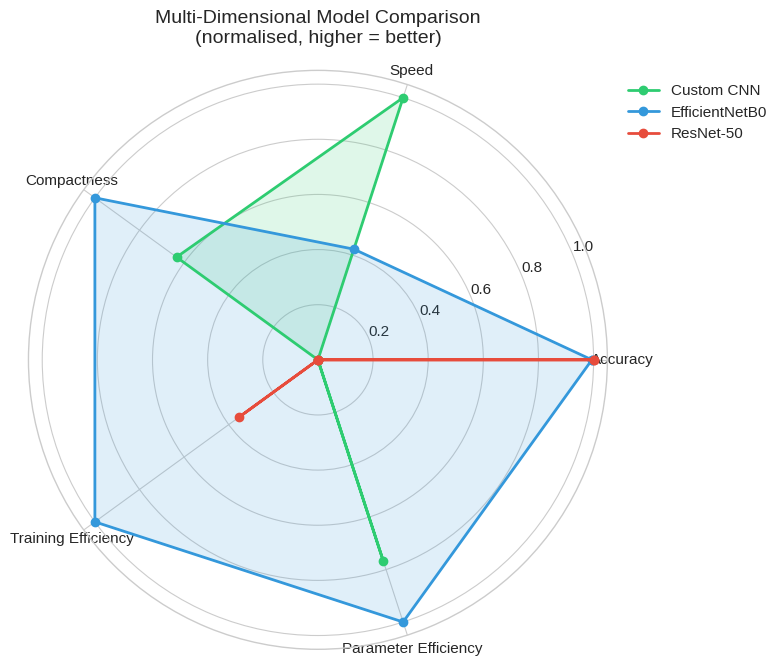


Plot saved: comparison_radar.png


In [11]:
# ============================================================================
# CELL 11: MULTI-DIMENSIONAL RADAR CHART
# ============================================================================
# Visualise trade-offs across multiple metrics simultaneously.
# ============================================================================

print("=" * 70)
print("MULTI-DIMENSIONAL COMPARISON")
print("=" * 70)

# Normalise metrics to 0-1 scale (higher = better for all)
metrics = {
    'Accuracy': [r['performance']['test_accuracy'] for r in results.values()],
    'Speed': [1/r['efficiency']['inference_time_single_ms'] for r in results.values()],
    'Compactness': [1/r['efficiency']['model_size_mb'] for r in results.values()],
    'Training Efficiency': [1/r['training']['training_time_seconds'] for r in results.values()],
    'Parameter Efficiency': [r['performance']['test_accuracy']/(r['efficiency']['total_parameters']/1e6) for r in results.values()]
}

# Normalise each metric
normalised = {}
for metric, values in metrics.items():
    min_v, max_v = min(values), max(values)
    if max_v > min_v:
        normalised[metric] = [(v - min_v) / (max_v - min_v) for v in values]
    else:
        normalised[metric] = [1.0] * len(values)

# Create radar chart
categories = list(normalised.keys())
n_cats = len(categories)
angles = [n / float(n_cats) * 2 * np.pi for n in range(n_cats)]
angles += angles[:1]  # Close the polygon

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, (model_name, color) in enumerate(COLORS.items()):
    values = [normalised[cat][i] for cat in categories]
    values += values[:1]  # Close polygon
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('Multi-Dimensional Model Comparison\n(normalised, higher = better)', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('/content/comparison_radar.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_radar.png")

In [ ]:
# ============================================================================
# CELL 12: COMPREHENSIVE GROUPED BAR CHART
# ============================================================================
# Single chart comparing ALL key metrics across all three models.
# Each model has a consistent colour; metrics are grouped as pillars.
# Metrics are normalised to percentage scale for visual comparison.
# ============================================================================

print("=" * 70)
print("COMPREHENSIVE MODEL COMPARISON CHART")
print("=" * 70)

import matplotlib.pyplot as plt
import numpy as np

# ---- Extract raw metrics ----
model_names = list(results.keys())

raw_metrics = {
    'Test\nAccuracy (%)': [
        r['performance']['test_accuracy'] * 100 for r in results.values()
    ],
    'Macro\nF1 Score': [
        np.mean([c['f1_score'] for c in r['per_class_metrics'].values()]) * 100
        for r in results.values()
    ],
    'Macro\nPrecision': [
        np.mean([c['precision'] for c in r['per_class_metrics'].values()]) * 100
        for r in results.values()
    ],
    'Macro\nRecall': [
        np.mean([c['recall'] for c in r['per_class_metrics'].values()]) * 100
        for r in results.values()
    ],
    'Parameters\n(M)': [
        r['efficiency']['total_parameters'] / 1e6 for r in results.values()
    ],
    'Model\nSize (MB)': [
        r['efficiency']['model_size_mb'] for r in results.values()
    ],
    'Inference\n(ms)': [
        r['efficiency']['inference_time_single_ms'] for r in results.values()
    ],
    'Training\nTime (h)': [
        r['training']['training_time_seconds'] / 3600 for r in results.values()
    ],
    'Total\nEpochs': [
        r['training']['total_epochs'] for r in results.values()
    ],
}

metric_names = list(raw_metrics.keys())
n_metrics = len(metric_names)
n_models = len(model_names)

# ---- Normalise to 0-100 per metric (for visual comparison) ----
normalised = {}
for metric, values in raw_metrics.items():
    max_val = max(values) if max(values) > 0 else 1
    normalised[metric] = [(v / max_val) * 100 for v in values]

# ---- Plot ----
fig, ax = plt.subplots(figsize=(18, 8))

bar_width = 0.22
x = np.arange(n_metrics)

for i, model_name in enumerate(model_names):
    values = [normalised[m][i] for m in metric_names]
    raw_vals = [raw_metrics[m][i] for m in metric_names]
    offset = (i - (n_models - 1) / 2) * bar_width
    bars = ax.bar(
        x + offset, values, bar_width,
        label=model_name,
        color=COLORS[model_name],
        edgecolor='black',
        linewidth=0.8,
        alpha=0.9
    )
    # Add raw value labels on top of each bar
    for bar, raw_val in zip(bars, raw_vals):
        height = bar.get_height()
        if raw_val >= 90:
            label = f'{raw_val:.2f}'
        elif raw_val >= 10:
            label = f'{raw_val:.1f}'
        elif raw_val >= 1:
            label = f'{raw_val:.2f}'
        else:
            label = f'{raw_val:.3f}'
        ax.text(
            bar.get_x() + bar.get_width() / 2, height + 1.5,
            label, ha='center', va='bottom',
            fontsize=7.5, fontweight='bold', rotation=0
        )

ax.set_ylabel('Normalised Scale (% of max per metric)', fontsize=12)
ax.set_title(
    'Comprehensive Model Comparison: All Metrics',
    fontsize=15, fontweight='bold', pad=15
)
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=10, ha='center')
ax.set_ylim(0, 120)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Add a subtle separator between performance and efficiency metrics
ax.axvline(x=3.5, color='gray', linestyle=':', alpha=0.4, linewidth=1)
ax.text(1.5, 115, 'PERFORMANCE', ha='center', fontsize=9,
        fontstyle='italic', color='gray', alpha=0.7)
ax.text(6.5, 115, 'EFFICIENCY & TRAINING', ha='center', fontsize=9,
        fontstyle='italic', color='gray', alpha=0.7)

plt.tight_layout()
plt.savefig('/content/comparison_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_comprehensive.png")
print("\nNote: Bar heights are normalised (tallest bar = 100% per metric).")
print("Raw values are displayed above each bar for exact comparison.")

In [ ]:
# ============================================================================
# CELL 13: MODEL PROFILE COMPARISON
# ============================================================================
# Each model displayed as its own group with all metrics side by side,
# using the model's signature colour. Allows quick visual profiling of
# each architecture's strengths and weaknesses in a single glance.
# ============================================================================

print("=" * 70)
print("MODEL PROFILE COMPARISON")
print("=" * 70)

import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())

# ---- Define metrics (short labels for this layout) ----
metric_defs = {
    'Accuracy':   lambda r: r['performance']['test_accuracy'] * 100,
    'F1 Score':   lambda r: np.mean([c['f1_score'] for c in r['per_class_metrics'].values()]) * 100,
    'Precision':  lambda r: np.mean([c['precision'] for c in r['per_class_metrics'].values()]) * 100,
    'Recall':     lambda r: np.mean([c['recall'] for c in r['per_class_metrics'].values()]) * 100,
    'Params (M)': lambda r: r['efficiency']['total_parameters'] / 1e6,
    'Size (MB)':  lambda r: r['efficiency']['model_size_mb'],
    'Infer (ms)': lambda r: r['efficiency']['inference_time_single_ms'],
    'Train (h)':  lambda r: r['training']['training_time_seconds'] / 3600,
    'Epochs':     lambda r: r['training']['total_epochs'],
}

metric_labels = list(metric_defs.keys())
n_metrics = len(metric_labels)

# ---- Extract raw values per model ----
raw_per_model = {}
for name, r in results.items():
    raw_per_model[name] = [fn(r) for fn in metric_defs.values()]

# ---- Normalise each metric across all models (0-100, max = 100) ----
all_values = {m: [] for m in metric_labels}
for name in model_names:
    for j, m in enumerate(metric_labels):
        all_values[m].append(raw_per_model[name][j])

norm_per_model = {}
for name in model_names:
    norm_per_model[name] = []
    for j, m in enumerate(metric_labels):
        max_val = max(all_values[m]) if max(all_values[m]) > 0 else 1
        norm_per_model[name].append(raw_per_model[name][j] / max_val * 100)

# ---- Plot: 3 model groups, each with n_metrics bars ----
fig, ax = plt.subplots(figsize=(18, 8))

bar_width = 0.7
group_gap = 2.5  # space between model groups
n_models = len(model_names)

positions = []  # track all bar positions for xtick placement
group_centres = []

x_cursor = 0
for i, model_name in enumerate(model_names):
    color = COLORS[model_name]
    model_positions = []

    for j in range(n_metrics):
        pos = x_cursor + j
        model_positions.append(pos)
        bar = ax.bar(
            pos, norm_per_model[model_name][j], bar_width,
            color=color, edgecolor='black', linewidth=0.6, alpha=0.88
        )
        # Raw value label
        raw_val = raw_per_model[model_name][j]
        if raw_val >= 90:
            label = f'{raw_val:.2f}'
        elif raw_val >= 10:
            label = f'{raw_val:.1f}'
        elif raw_val >= 1:
            label = f'{raw_val:.2f}'
        else:
            label = f'{raw_val:.3f}'
        ax.text(
            pos, norm_per_model[model_name][j] + 1.5, label,
            ha='center', va='bottom', fontsize=7.5, fontweight='bold'
        )

    positions.extend(model_positions)
    group_centres.append(np.mean(model_positions))
    x_cursor += n_metrics + group_gap

# X-axis: metric labels repeated under each group
ax.set_xticks(positions)
ax.set_xticklabels(metric_labels * n_models, fontsize=8.5, rotation=45, ha='right')

# Model name labels above each group
for centre, name in zip(group_centres, model_names):
    ax.text(
        centre, 113, name, ha='center', va='bottom',
        fontsize=13, fontweight='bold', color=COLORS[name],
        bbox=dict(boxstyle='round,pad=0.3', facecolor=COLORS[name],
                  alpha=0.15, edgecolor=COLORS[name], linewidth=1.5)
    )

# Vertical separators between groups
for i in range(1, n_models):
    sep_x = group_centres[i-1] + (group_centres[i] - group_centres[i-1]) / 2
    ax.axvline(x=sep_x, color='gray', linestyle='--', alpha=0.3, linewidth=1)

ax.set_ylabel('Normalised Scale (% of max per metric)', fontsize=12)
ax.set_title(
    'Model Profiles: Per-Architecture Metric Breakdown',
    fontsize=15, fontweight='bold', pad=20
)
ax.set_ylim(0, 125)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/comparison_model_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: comparison_model_profiles.png")
print("\nEach group shows one model\'s full metric profile in its signature colour.")
print("Raw values displayed above bars; heights normalised across models per metric.")

In [12]:
# ============================================================================
# CELL 12: COMPREHENSIVE RESULTS TABLE
# ============================================================================
# Full breakdown suitable for dissertation appendix.
# ============================================================================

print("=" * 70)
print("COMPREHENSIVE RESULTS")
print("=" * 70)

detailed_data = []
for name, r in results.items():
    # Calculate macro-averaged metrics from per-class data
    classes = r['per_class_metrics']
    macro_precision = np.mean([c['precision'] for c in classes.values()])
    macro_recall = np.mean([c['recall'] for c in classes.values()])
    macro_f1 = np.mean([c['f1_score'] for c in classes.values()])

    detailed_data.append({
        'Model': name,
        'Architecture': r['architecture'].get('type', 'Transfer Learning'),
        'Test Accuracy': f"{r['performance']['test_accuracy']*100:.2f}%",
        'Macro Precision': f"{macro_precision:.4f}",
        'Macro Recall': f"{macro_recall:.4f}",
        'Macro F1': f"{macro_f1:.4f}",
        'Parameters': f"{r['efficiency']['total_parameters']:,}",
        'Size (MB)': r['efficiency']['model_size_mb'],
        'Training (h)': round(r['training']['training_time_seconds']/3600, 2),
        'Epochs': r['training']['total_epochs'],
        'Best Epoch': r['training']['best_epoch']
    })

detailed_df = pd.DataFrame(detailed_data)
print(detailed_df.to_string(index=False))

COMPREHENSIVE RESULTS
         Model              Architecture Test Accuracy Macro Precision Macro Recall Macro F1 Parameters  Size (MB)  Training (h)  Epochs  Best Epoch
    Custom CNN Custom CNN (from scratch)        97.97%          0.9686       0.9895   0.9781  4,964,942      56.92         14.78      50          45
EfficientNetB0         Transfer Learning        99.75%          0.9972       0.9972   0.9972  4,072,625      40.03          6.67      28          25
     ResNet-50         Transfer Learning        99.76%          0.9971       0.9972   0.9971 24,125,070     211.03         10.34      40          39


In [ ]:
# ============================================================================
# CELL 14: SAVE COMPARISON OUTPUTS
# ============================================================================
# Export comparison results and copy plots to Drive.
# ============================================================================

import shutil

print("=" * 70)
print("SAVING OUTPUTS")
print("=" * 70)

COMPARISON_DIR = f"{RESULTS_DIR}/comparison"
os.makedirs(COMPARISON_DIR, exist_ok=True)

# Save summary CSV
summary_df.to_csv(f"{COMPARISON_DIR}/model_comparison_summary.csv", index=False)
print(f"Saved: model_comparison_summary.csv")

# Save detailed CSV
detailed_df.to_csv(f"{COMPARISON_DIR}/model_comparison_detailed.csv", index=False)
print(f"Saved: model_comparison_detailed.csv")

# Save F1 heatmap data
f1_df.to_csv(f"{COMPARISON_DIR}/per_class_f1_scores.csv")
print(f"Saved: per_class_f1_scores.csv")

# Copy plots
plots = [
    'comparison_accuracy.png',
    'comparison_efficiency.png',
    'comparison_f1_heatmap.png',
    'comparison_tradeoff.png',
    'comparison_radar.png',
    'comparison_comprehensive.png',
    'comparison_model_profiles.png'
]

for plot in plots:
    src = f'/content/{plot}'
    if os.path.exists(src):
        shutil.copy(src, f"{COMPARISON_DIR}/{plot}")
        print(f"Saved: {plot}")

print(f"\nAll outputs saved to: {COMPARISON_DIR}")

In [ ]:
# ============================================================================
# CELL 15: FINAL SUMMARY AND CONCLUSIONS
# ============================================================================

print("=" * 70)
print("MODEL COMPARISON - FINAL SUMMARY")
print("=" * 70)

# Extract key metrics
cnn = results['Custom CNN']
eff = results['EfficientNetB0']
res = results['ResNet-50']

print(f"""
EXPERIMENT CONFIGURATION
----------------------------------------------------------------------
Dataset:        SnapShelf 14-class food classification
Train/Val/Test: 84,582 / 18,119 / 18,141 images
Image Size:     224x224 RGB
Class Imbalance: 113:1 (handled via class weights)
Augmentation:   Rotation, shifts, shear, zoom, horizontal flip

PERFORMANCE RESULTS
----------------------------------------------------------------------
                    Custom CNN    EfficientNetB0    ResNet-50
Test Accuracy       {cnn['performance']['test_accuracy']*100:.2f}%         {eff['performance']['test_accuracy']*100:.2f}%           {res['performance']['test_accuracy']*100:.2f}%
Test Loss           {cnn['performance']['test_loss']:.4f}          {eff['performance']['test_loss']:.4f}            {res['performance']['test_loss']:.4f}
Parameters          {cnn['efficiency']['total_parameters']/1e6:.2f}M          {eff['efficiency']['total_parameters']/1e6:.2f}M            {res['efficiency']['total_parameters']/1e6:.2f}M
Model Size          {cnn['efficiency']['model_size_mb']:.1f}MB         {eff['efficiency']['model_size_mb']:.1f}MB           {res['efficiency']['model_size_mb']:.1f}MB
Training Time       {cnn['training']['training_time_seconds']/3600:.1f}h*          {eff['training']['training_time_seconds']/3600:.1f}h             {res['training']['training_time_seconds']/3600:.1f}h

* Custom CNN training time estimated via per-epoch extrapolation due to
  a runtime interruption at epoch 66 (see Cell 4 correction note).

KEY FINDINGS
----------------------------------------------------------------------
1. Transfer learning models (EfficientNetB0, ResNet-50) significantly
   outperform the Custom CNN baseline by ~1.8 percentage points.

2. EfficientNetB0 achieves comparable accuracy to ResNet-50 while being
   significantly smaller and faster to train.

3. The Custom CNN trained from scratch required {cnn['training']['training_time_seconds']/3600:.1f}h for 81
   epochs, confirming the computational cost of learning features from
   random initialisation versus leveraging pretrained ImageNet weights.

4. All models handle the severe class imbalance effectively,
   maintaining high F1 scores across minority classes.

RECOMMENDATION
----------------------------------------------------------------------
EfficientNetB0 is the recommended model for deployment due to its
optimal balance of accuracy ({eff['performance']['test_accuracy']*100:.2f}%), efficiency ({eff['efficiency']['model_size_mb']:.0f}MB),
and training cost ({eff['training']['training_time_seconds']/3600:.1f} hours).
""")

print("=" * 70)
print("COMPARISON ANALYSIS COMPLETE")
print("=" * 70)